In this notebook, we extract shapley values and visualize them

In [1]:
# read the file names and split into train test with size 50%
from read_data import read_save
read_save()

from read_data import tr_test_split
train_data_files, test_data_files = tr_test_split(0.5)

In [2]:
# generate features from the data (node features and connectivity)
from read_data import build_data
from read_data import stack_arrays
from process import label2skip, uniform, standardize_data, get_lap

train_X, train_graphs, train_y = build_data(train_data_files, size=500, cal_conn="corr", bands=True)
test_X, test_graphs, test_y = build_data(test_data_files, size=500, cal_conn="corr", bands=True)
train_X_orig, train_graphs_orig, train_y_orig = stack_arrays(train_X, train_graphs, train_y)
test_X_orig, test_graphs_orig, test_y_orig = stack_arrays(test_X, test_graphs, test_y)

train_graphs, train_X, train_y =  label2skip(train_graphs_orig, train_X_orig, train_y_orig, skip_label=1)
test_graphs, test_X, test_y =  label2skip(test_graphs_orig, test_X_orig, test_y_orig, skip_label=1)
train_graphs, test_graphs = uniform(train_graphs, test_graphs)
train_X, test_X = standardize_data(train_X, test_X)
train_graphs = get_lap(train_graphs)
test_graphs = get_lap(test_graphs)

100%|██████████████████████████████████████| 2911/2911 [00:10<00:00, 288.35it/s]


In [4]:
# build pytorch data loader and start training
from sklearn.preprocessing import OneHotEncoder
from process import data_loader
from train import trainer
import torch

DEVICE = torch.device("cpu")
BATCH_SIZE = 200

encoder = OneHotEncoder()
train_y_ohe = encoder.fit_transform(train_y).toarray()
test_y_ohe = encoder.transform(test_y).toarray()

train_iter = data_loader(train_X, train_graphs, train_y_ohe, DEVICE, BATCH_SIZE, shuffle=True)
test_iter = data_loader(test_X, test_graphs, test_y_ohe, DEVICE, BATCH_SIZE, shuffle=False)

model = trainer(20, train_iter)

Training Model....


100%|███████████████████████████████████████████| 20/20 [00:24<00:00,  1.23s/it]


In [7]:
# measure evaluation metrics
from evaluate import cal_accuracy

print("Train Accuracy")
train_acc = cal_accuracy(model, train_iter)
print("Accuracy: ", train_acc[0])
print("Precision: ", train_acc[2])
print("Recall: ", train_acc[3])
print("F1: ", train_acc[4])
print("Confusion Matrix: ", train_acc[1])

print("Test Accuracy")
test_acc = cal_accuracy(model, test_iter)
print("Accuracy: ", test_acc[0])
print("Precision: ", test_acc[2])
print("Recall: ", test_acc[3])
print("F1: ", test_acc[4])
print("Confusion Matrix: ", test_acc[1])

Train Accuracy
Accuracy:  1.0
Precision:  [1. 1.]
Recall:  [1. 1.]
F1:  [1. 1.]
Confusion Matrix:  [[3010    0]
 [   0 1212]]
Test Accuracy
Accuracy:  1.0
Precision:  [1. 1.]
Recall:  [1. 1.]
F1:  [1. 1.]
Confusion Matrix:  [[1936    0]
 [   0  975]]


In [30]:
# generate shapley values for the test data node features
import shap
test_X = torch.Tensor(test_X)
test_graphs = torch.Tensor(test_graphs)
train_X = torch.Tensor(train_X)
train_graphs = torch.Tensor(train_graphs)

e = shap.DeepExplainer(model, [train_X[:1000], train_graphs[:1000]])
shap_values = e.shap_values([test_X, test_graphs], check_additivity=False)
node_values = np.mean(shap_values[0][:, :, :, 3, :], axis=2)
test_X_avg = np.mean(test_X[:, :, :, 3].numpy(), axis=-1)

In [129]:
ch_names_renamed =  ['Fp1', 'Fp2', 'F7', 'F3','Fz','F4','F8','T3','C3','Cz','C4','T4','T5','P3','Pz','P4','T6','O1','O2']
exp = shap.Explanation(node_values, data = test_X_avg, feature_names=ch_names_renamed)

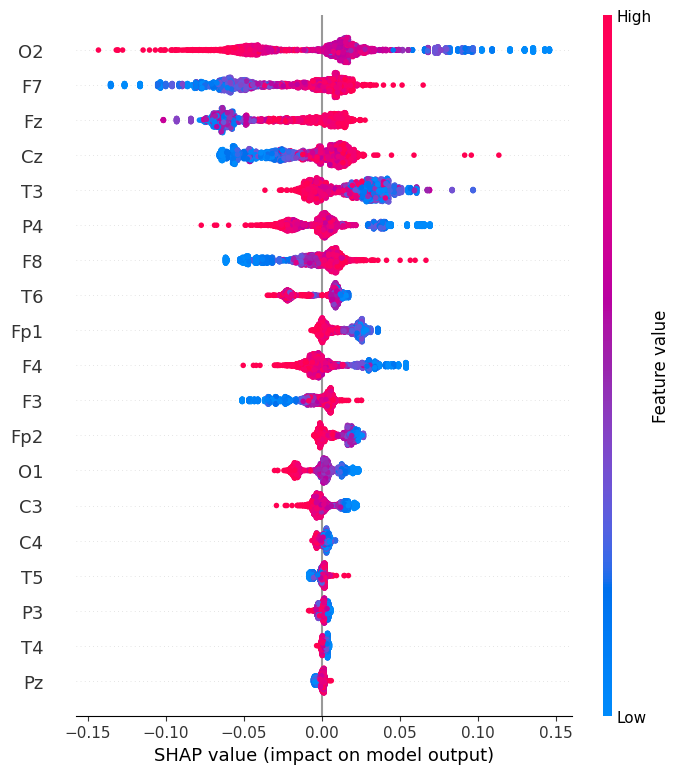

In [131]:
shap.plots.beeswarm(exp[:, :, 0], max_display=19)

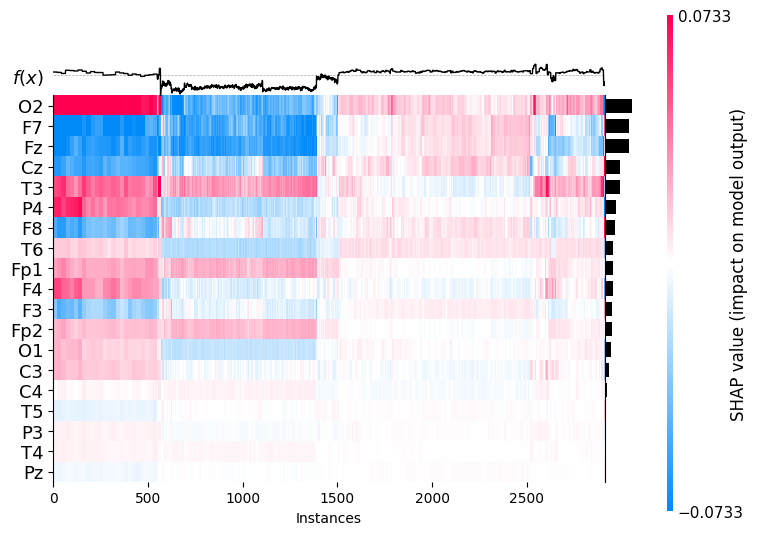

<AxesSubplot:xlabel='Instances'>

In [136]:
shap.plots.heatmap(exp[:, :, 0], max_display=19)